# Estimating Neandertal ancestry over time

In [1]:
library(here)
library(tidyverse)
library(ggrepel)
library(future)
library(furrr)
plan(multiprocess)

library(admixr)
library(bdkn)

source(here("code/utils.R"))

here() starts at /mnt/expressions/mp/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%


Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
plot_nea_vs_time <- function(df, snp_cutoff=0, oldest=Inf, youngest=-Inf, ylim=c(0, 0.1), plot_ci=TRUE) {
    filter(df,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count), alpha=3/4) +
        geom_errorbar(aes(ymin=alpha - 2 * stderr, ymax=alpha + 2 * stderr)) +
        geom_smooth(aes(weight=snp_count), data=., method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlab("age [years before present]") + ylab("Neanderthal ancestry proportion") +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) #+
        #ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(df, snp_cutoff=0, oldest=Inf, youngest=0) {
    filter(df,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) }
}

In [3]:
samples <- load_samples() %>%
    filter(!pop %in% c("Oceania")) %>%
    mutate(name = case_when(name == "new_UstIshim" ~ "UstIshim",
                            name == "new_Loschbour" ~ "Loschbour",
                            TRUE ~ name))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [4]:
suppressMessages(
array_snps <- load_dataset(here("data/genotypes/ice_age.tsv"),
                           here("data/genotypes/sgdp.tsv"),
                           here("data/genotypes/archaics.tsv"),
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha))

In [5]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [6]:
snps <- eigenstrat(here("data/eigenstrat/bigyri_ho/all"))

### Calculate the number of SNPs available for each sample on the 2.2M array

In [7]:
snp_counts_f4 <- count_snps(snps)

## Nea. ancestry proportions using the indirect f4-ratio

In [8]:
indirect_f4 %<-% {
    relabel(snps,
            West_and_Central_Africans = c("Yoruba", "Mbuti", "Mende"),
            Archaics = c("new_Altai", "new_Denisova")) %>%
    f4ratio(X = filter(samples, pop %in% c("EMH", "WestEurasia"))$name,
            A = "West_and_Central_Africans", B = "Archaics", C = "Dinka", O = "Chimp")
}

In [9]:
indirect_f4 %<>% mutate(stat = "indirect_f4")

In [10]:
afr_pops <- list(
    c("Yoruba", "Dinka"),
    c("Mbuti", "Dinka"),
    c("Khomani_San", "Dinka"),
    c("Mbuti", "Yoruba"),
    c("Khomani_San", "Yoruba"),
    c("Khomani_San", "Mbuti")
)

indirect_f4_combinations <- future_map_dfr(
    afr_pops,
    ~ f4ratio(X = filter(samples, pop %in% c("EMH", "WestEurasia"))$name,
            A = .x[1], B = "new_Altai", C = .x[2], O = "Chimp", data = snps)
)

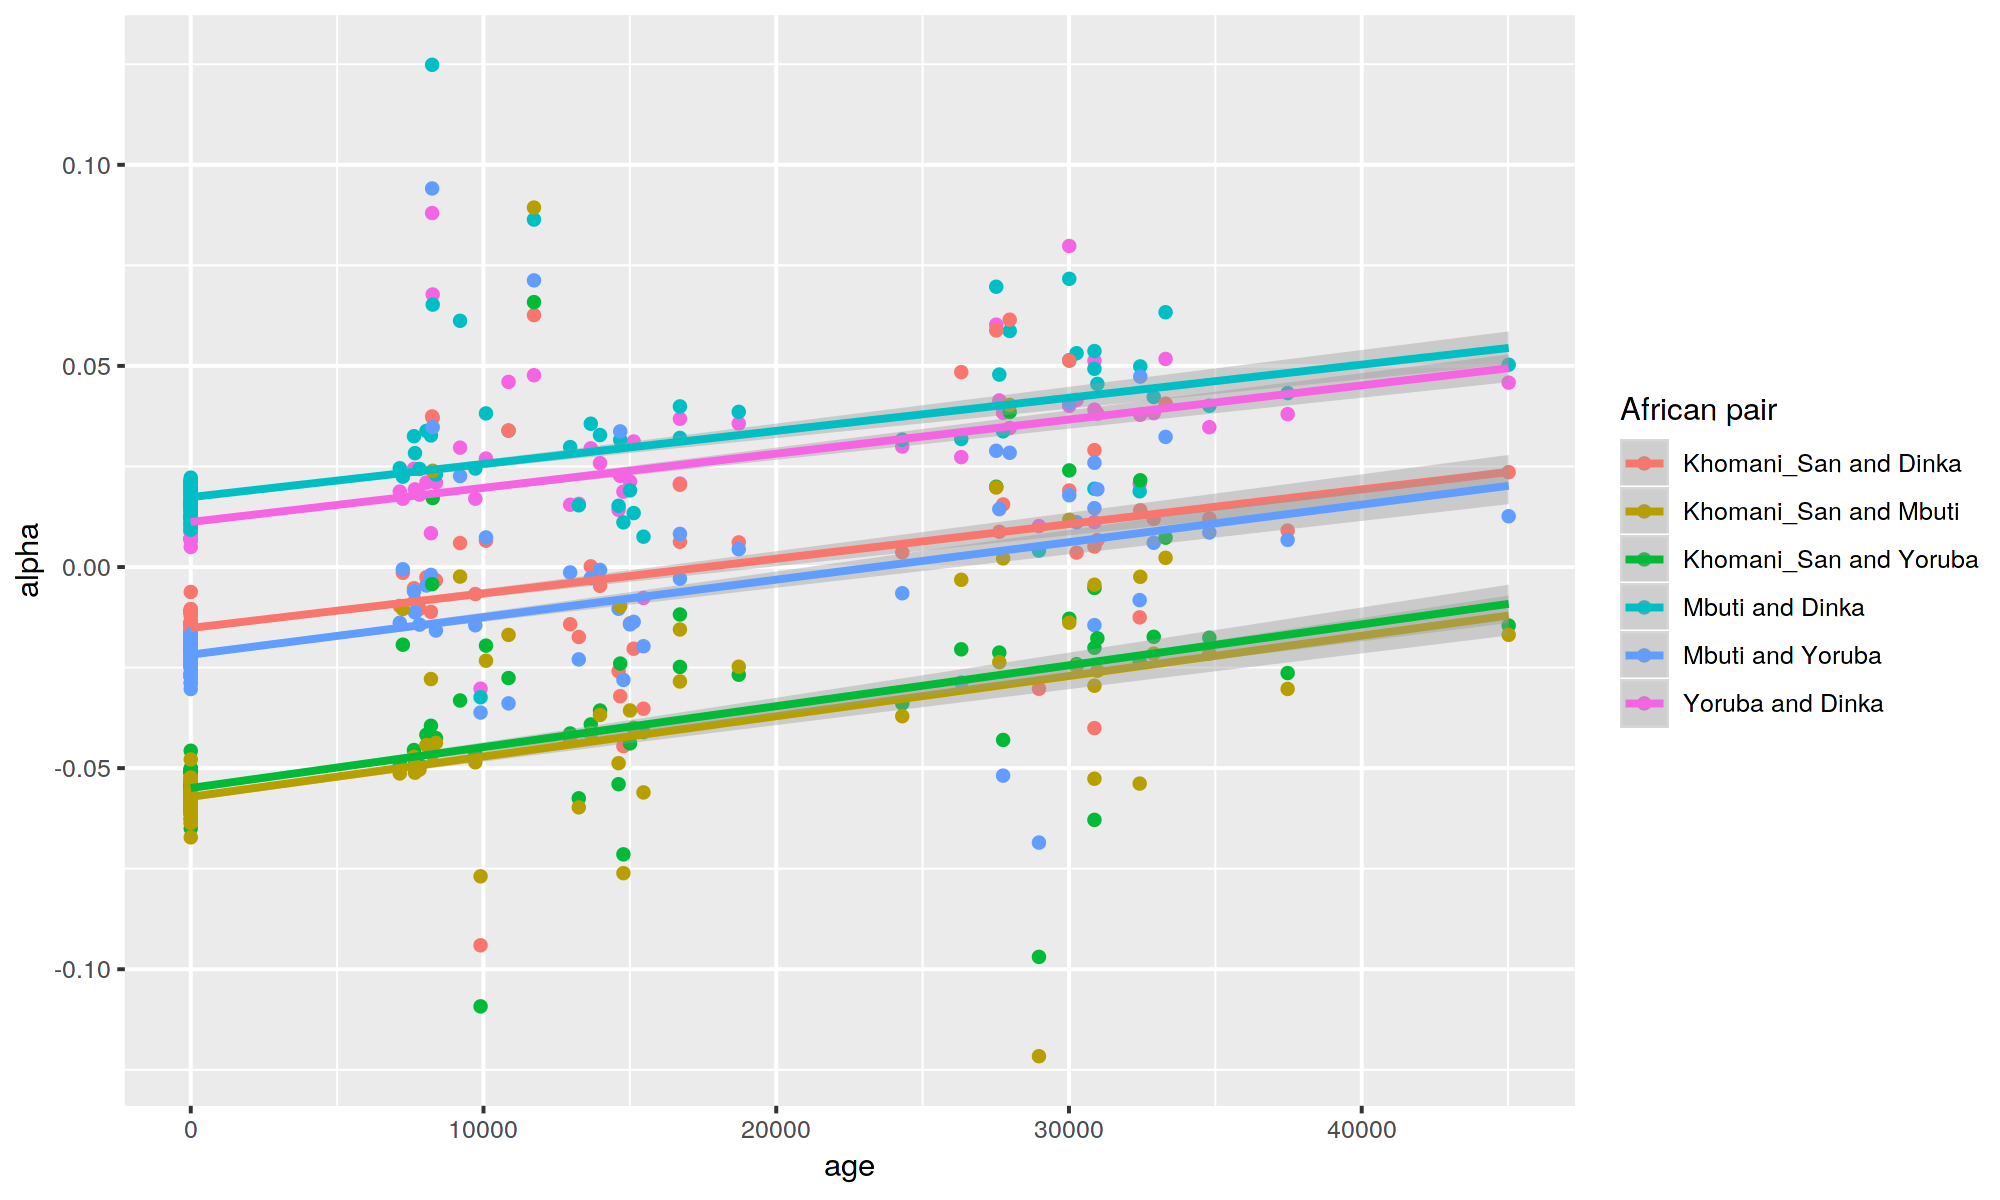

In [11]:
set_dim(10, 6, 200)

inner_join(indirect_f4_combinations, samples, by = c("X" = "name")) %>%
inner_join(snp_counts_f4, by = c("X" = "label")) %>% 
mutate(afr_pair = A %+% " and " %+% C) %>%
ggplot(aes(age, alpha, color = afr_pair)) + geom_point() + geom_smooth(aes(weight = present), method = "lm") +
scale_color_discrete(name = "African pair")

## Nea. ancestry using the direct f4-ratio using various African populations

In [44]:
direct_f4 <- future_map_dfr(
    filter(samples, pop == "Africa")$name, 
    ~ f4ratio(X = filter(samples, pop %in% c("EMH", "WestEurasia"))$name,
            A = "new_Altai", B = "new_Vindija", C = .x, O = "Chimp", data = snps)
)
direct_f4 %<>% mutate(stat = "direct_f4")

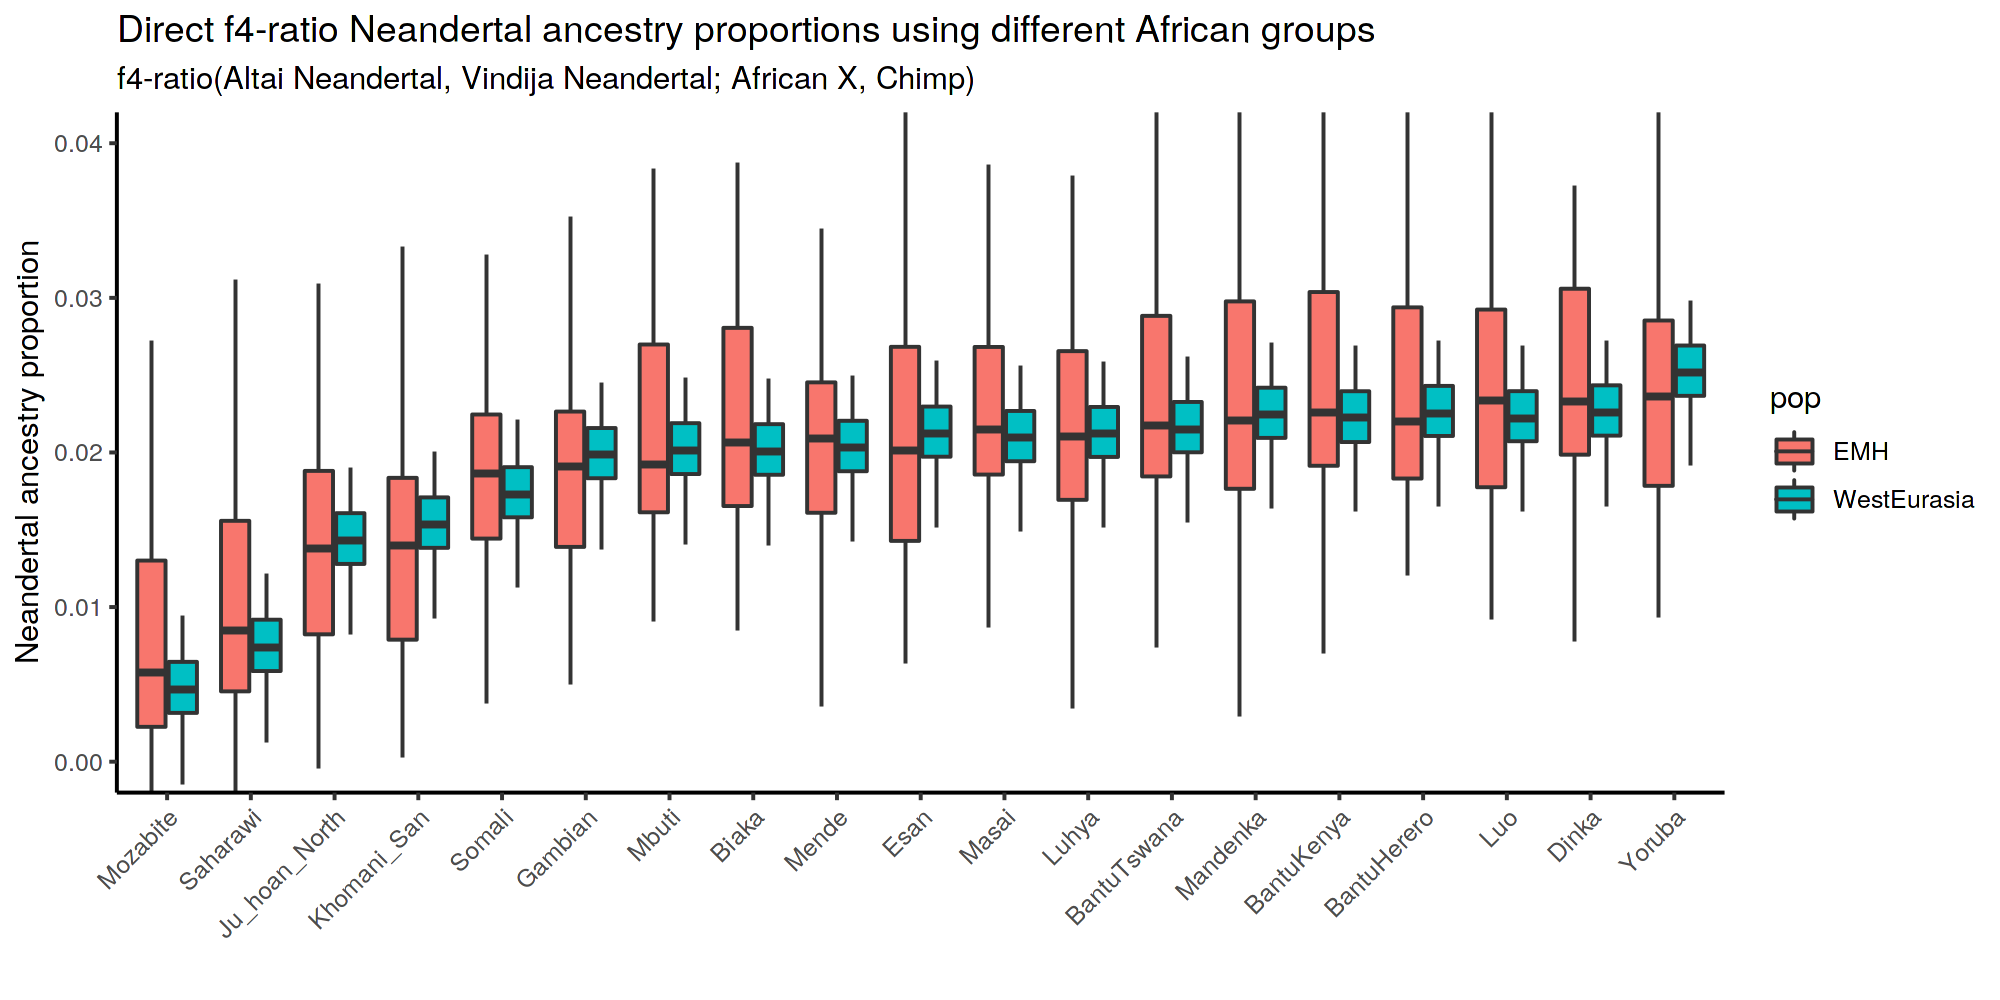

In [45]:
set_dim(10, 5, 200)

inner_join(direct_f4, samples, by = c("X" = "name")) %>%
ggplot(aes(fct_reorder(C, alpha), alpha, fill = pop)) +
    geom_boxplot(outlier.shape = NA) + coord_cartesian(y = c(0, 0.04)) +
    theme_classic() + theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("Direct f4-ratio Neandertal ancestry proportions using different African groups",
            "f4-ratio(Altai Neandertal, Vindija Neandertal; African X, Chimp)") +
    xlab("") + ylab("Neandertal ancestry proportion")

## Pairwise sharing of Neandertal alleles among Africans

In [14]:
pairf4 <- future_map_dfr(
    filter(samples, pop == "Africa")$name, 
    ~ f4(W = setdiff(filter(samples, pop == "Africa")$name, .x),
         X = .x, Y = "new_Vindija", Z = "Chimp", data = snps)
)

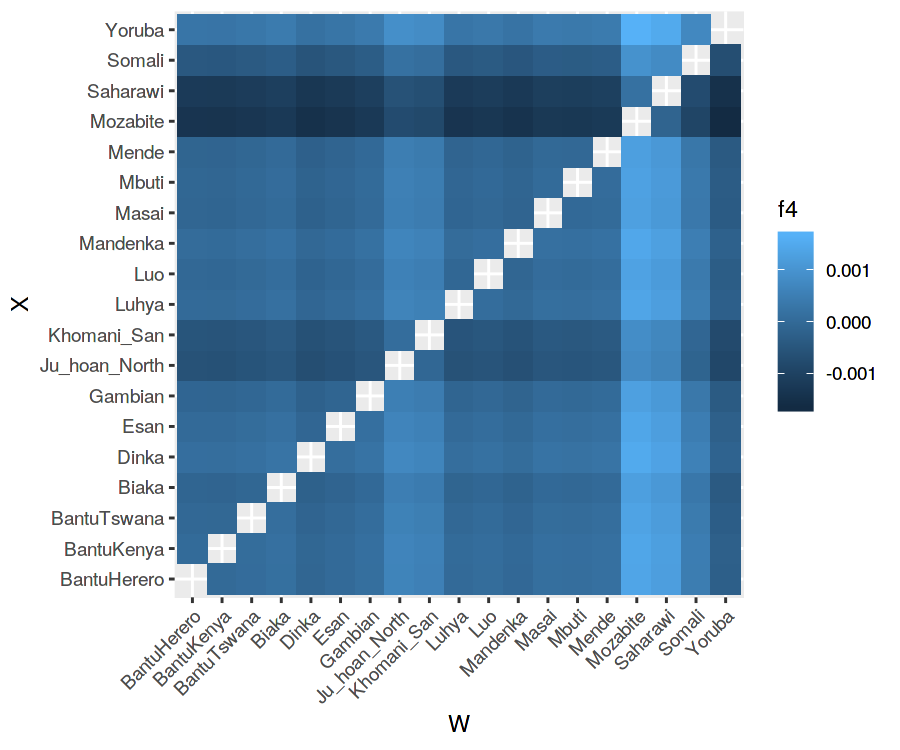

In [15]:
set_dim(6, 5)

pairf4 %>%
ggplot(aes(W, X, fill = f4)) + geom_tile() + theme(axis.text.x = element_text(hjust = 1, angle = 45))

## qpAdm Neandertal ancestry estimates

In [16]:
qpAdm_result %<-% qpAdm(target = filter(samples, pop %in% c("EMH", "WestEurasia"))$name,
                        references = c("new_Vindija", "Mbuti"),
                        outgroups = c("Chimp", "new_Altai", "new_Denisova"),
                        data=snps)

In [42]:
qpAdm_result$ranks %>% head

target,rank,df,chisq,tail,dfdiff,chisqdiff,taildiff
UstIshim,1,1,1.726,0.18892708,3,-1.726,1.00000000
UstIshim,2,0,0.000,1.00000000,1,1.726,0.18892708
Kostenki14,1,1,3.657,0.05583357,3,-3.657,1.00000000
Kostenki14,2,0,0.000,1.00000000,1,3.657,0.05583357
GoyetQ116-1,1,1,3.011,0.08271362,3,-3.011,1.00000000
GoyetQ116-1,2,0,0.000,1.00000000,1,3.011,0.08271362


In [17]:
qpAdm_result$proportions %<>% mutate(stat = "qpAdm")

In [18]:
qpAdm_result$proportions %>% head

target,new_Vindija,Mbuti,stderr_new_Vindija,stderr_Mbuti,nsnps,stat
UstIshim,0.02417607,0.9758239,0.004,0.004,2050585,qpAdm
Kostenki14,0.01941863,0.9805814,0.004,0.004,1676430,qpAdm
GoyetQ116-1,0.02800516,0.9719948,0.004,0.004,811826,qpAdm
Muierii2,0.01659132,0.9834087,0.009,0.009,95793,qpAdm
Paglicci133,0.02347815,0.9765219,0.010,0.010,79635,qpAdm
Cioclovina1,0.02432771,0.9756723,0.024,0.024,12426,qpAdm


### Merge all f4 results:

In [19]:
results <- bind_rows(
    inner_join(bind_rows(indirect_f4,
                         indirect_f4_combinations,
                         direct_f4,
                         mutate(qpAdm_result$proportions, C = "Yoruba") %>%
                             select(target, stat, C, new_Vindija, stderr = stderr_new_Vindija) %>%
                             rename(X = target, alpha = new_Vindija)
               ),
               rename(snp_counts_f4, snp_count = present), by = c("X" = "label")) %>% mutate(sites="all"),
    inner_join(direct_nea, snp_counts_direct) %>% rename(X = name) %>% mutate(sites = "admixture_array", stat = "admixture_prop")
) %>%
    inner_join(samples, by=c("X"="name"))

Joining, by = "name"


### How does the average amount of Neandertal ancestry in West Eurasians using various African populations depend on the Neandertal ancestry in those Africans?

In [20]:
afr_f4 %<-% f4(
    W = setdiff(filter(samples, pop == "Africa")$name, "Yoruba"),
    X = "Yoruba", Y = "new_Vindija", Z = "Chimp",
    data = snps
)

In [21]:
mean_direct_f4 <- filter(results, stat == "direct_f4", pop == "WestEurasia", C != "Yoruba") %>%
group_by(C) %>%
summarise(mean_Nea = mean(alpha))

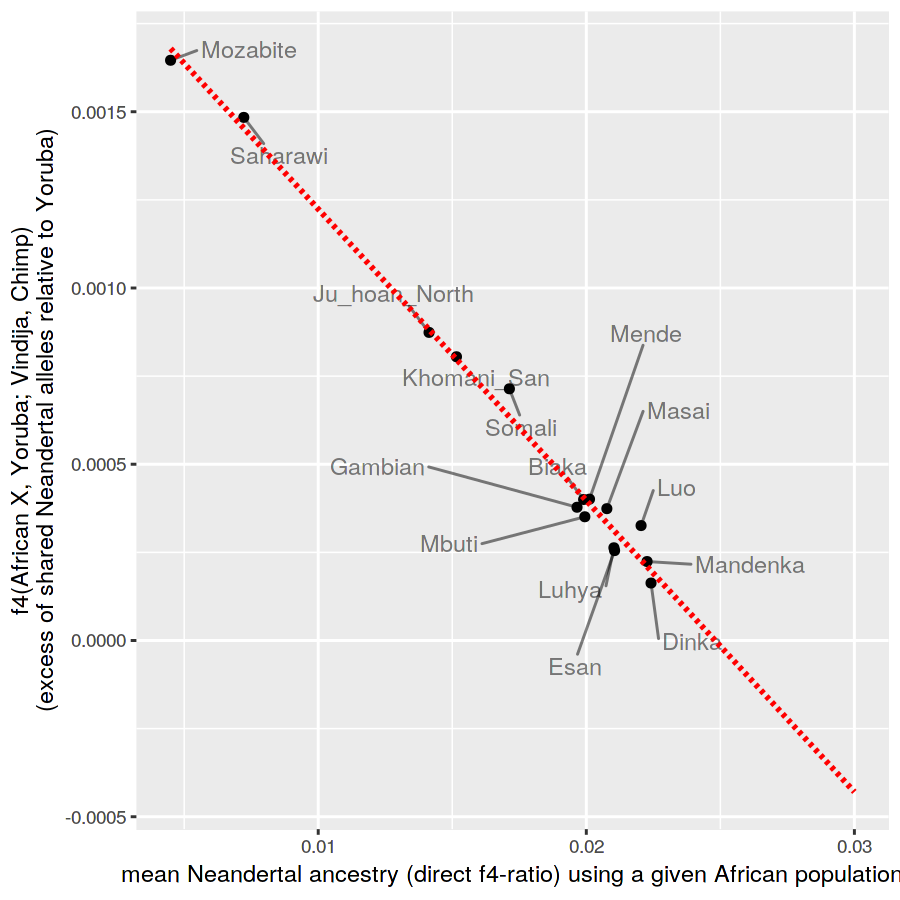

In [22]:
set_dim(6, 6, 150)

inner_join(mean_direct_f4, afr_f4, by = c("C" = "W")) %>%
filter(C %notin% c("BantuHerero", "BantuHerero", "BantuKenya", "BantuTswana")) %>% 
ggplot(aes(mean_Nea, f4)) + geom_point() +
    geom_text_repel(aes(label = C), box.padding = 1, alpha = 0.5) +
    geom_smooth(method = "lm", color = "red", linetype = 2, fullrange = TRUE, se = FALSE) +
    xlab("mean Neandertal ancestry (direct f4-ratio) using a given African population") +
    ylab("f4(African X, Yoruba; Vindija, Chimp)\n(excess of shared Neandertal alleles relative to Yoruba)") +
    expand_limits(x = 0.03)

# Plot Nea. estimates over time

In [23]:
set_dim(9, 5)

In [24]:
non_udg_samples <- NULL #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

In [25]:
near_east <- c("BedouinB", "Druze", "Iranian", "Iraqi_Jew", "Jordanian",
               "Palestinian", "Samaritan", "Yemenite_Jew")

In [26]:
eur_nea <- filter(results, pop %in% c("EMH", "WestEurasia"),
                  !X %in% non_udg_samples,
                  !X %in% near_east)

## Results from the Ice Age paper

In [27]:
cutoff <- 200000

In [28]:
set_dim(9, 5)

Warning message:
“Removed 48 rows containing missing values (geom_errorbar).”

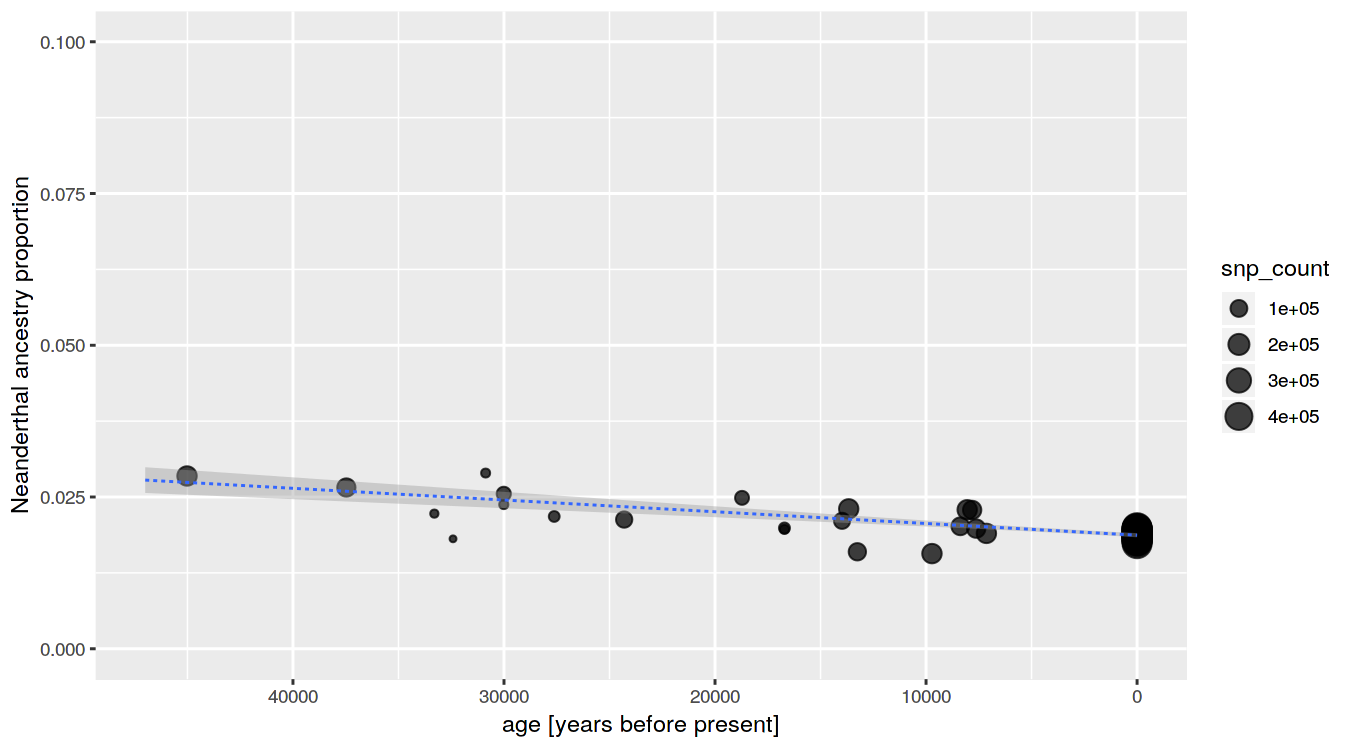

In [29]:
filter(eur_nea, stat == "admixture_prop") %>%
plot_nea_vs_time(snp_cutoff = 2000)

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

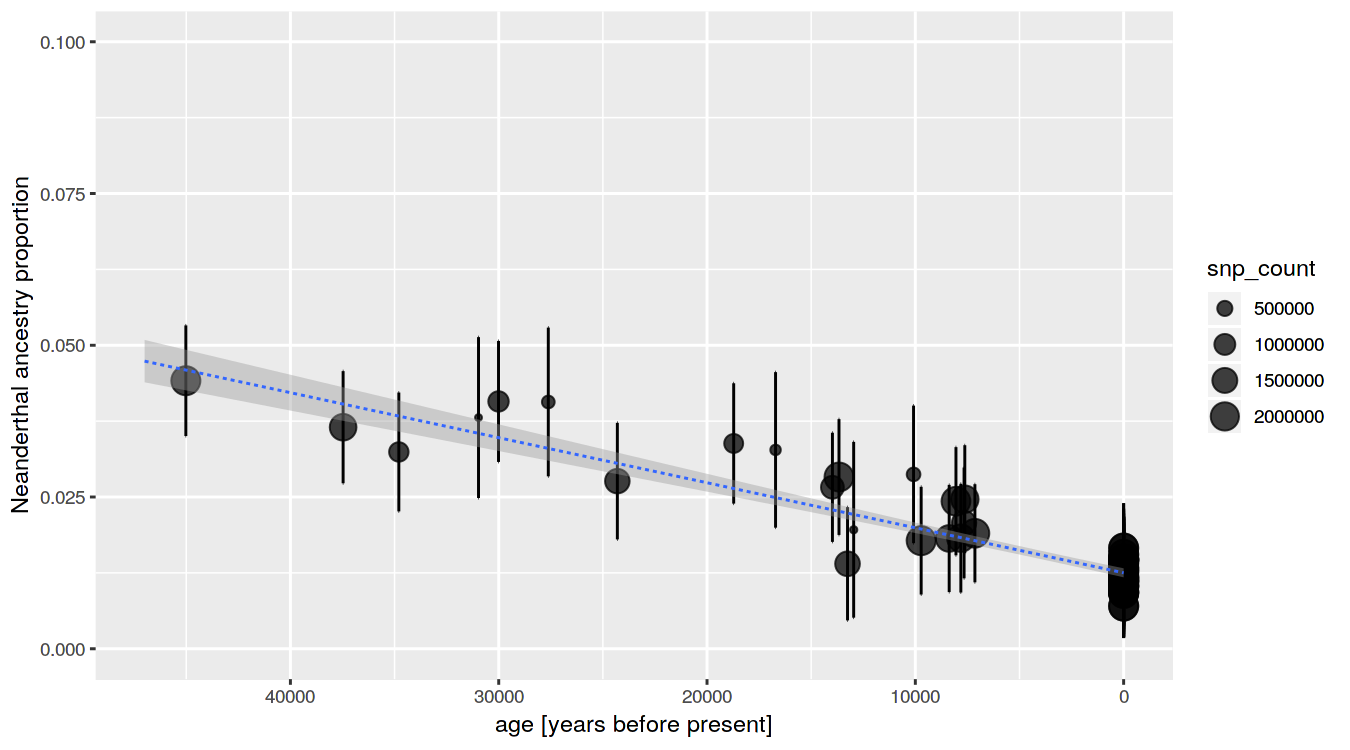

In [30]:
eur_nea %>% filter(A == "West_and_Central_Africans") %>%
plot_nea_vs_time(ylim = c(0, 0.1), snp_cutoff = cutoff)

# qpAdm results


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9327328 -5712795 -3953798  4542900 57763181 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    -10751      10335  -1.040    0.302
.[["alpha"]]   672692     487664   1.379    0.172

Residual standard error: 12060000 on 71 degrees of freedom
Multiple R-squared:  0.0261,	Adjusted R-squared:  0.01238 
F-statistic: 1.903 on 1 and 71 DF,  p-value: 0.1721


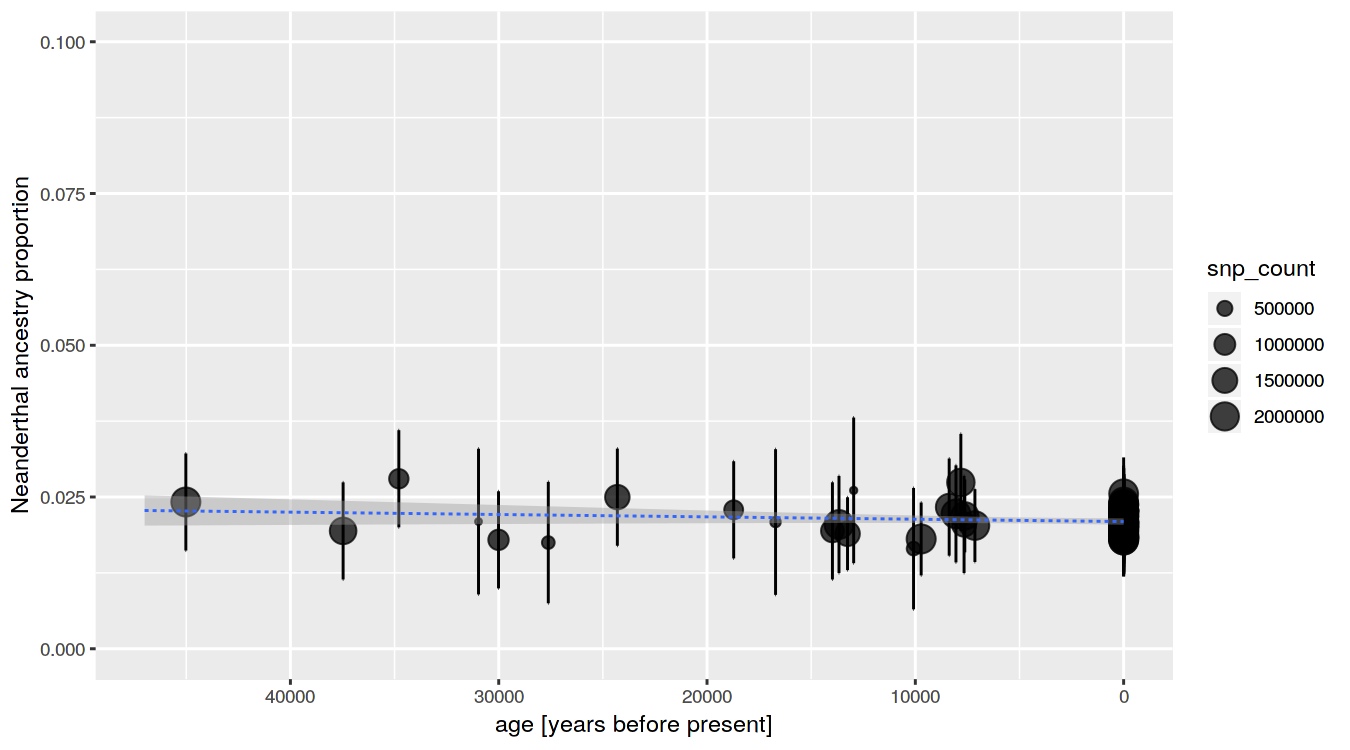

In [31]:
filter(eur_nea, stat == "qpAdm") %>% {
    print(plot_nea_vs_time(., snp_cutoff = cutoff))
    summary(run_lm(., snp_cutoff = cutoff))
}

qpAdm vs direct f4

Warning message:
“Ignoring unknown parameters: a”

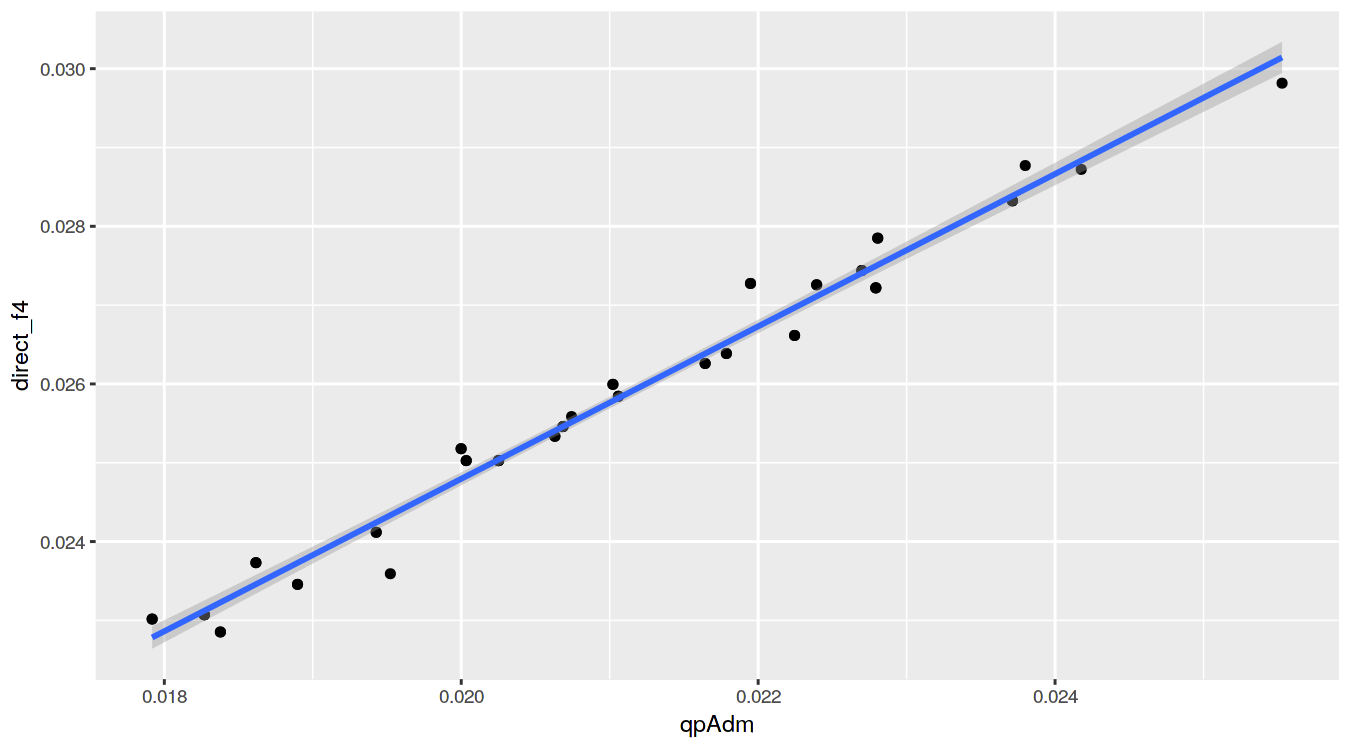

In [32]:
qplot(x = (eur_nea %>% filter(stat == "qpAdm", pop == "WestEurasia"))$alpha,
      y = (eur_nea %>% filter(stat == "direct_f4", pop == "WestEurasia", C == "Yoruba"))$alpha,
      xlab = "qpAdm", ylab = "direct_f4") +
geom_smooth(a = 1, method = "lm")

# New f4 results

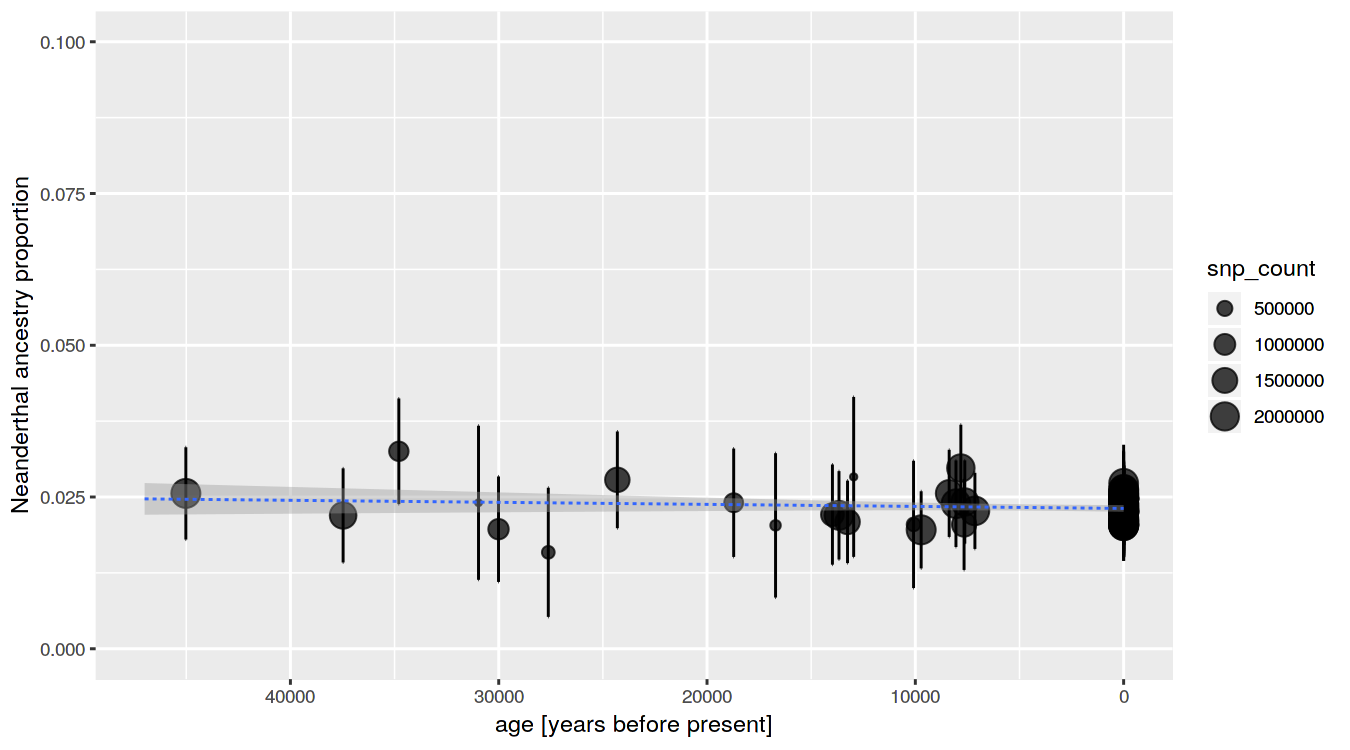

In [33]:
eur_nea %>% filter(stat == "direct_f4", C == "Dinka") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

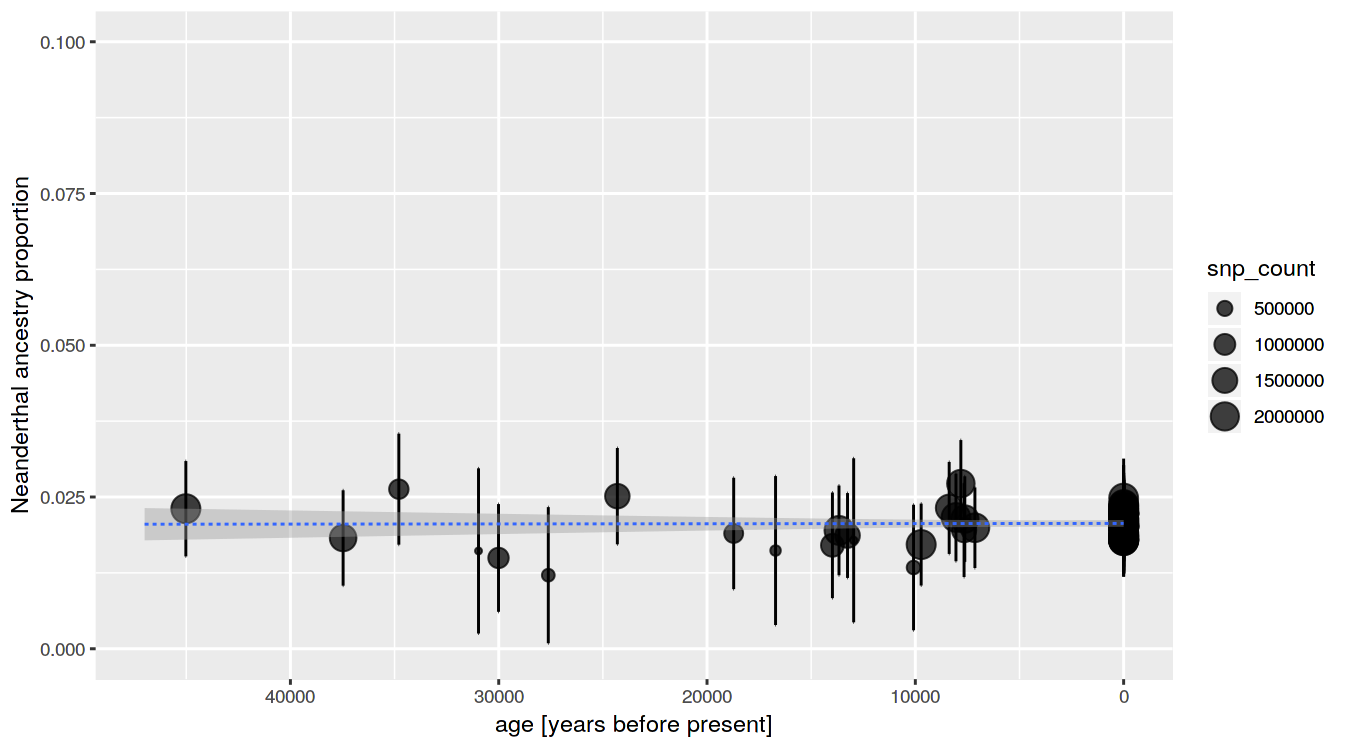

In [34]:
eur_nea %>% filter(stat == "direct_f4", C == "Mbuti") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

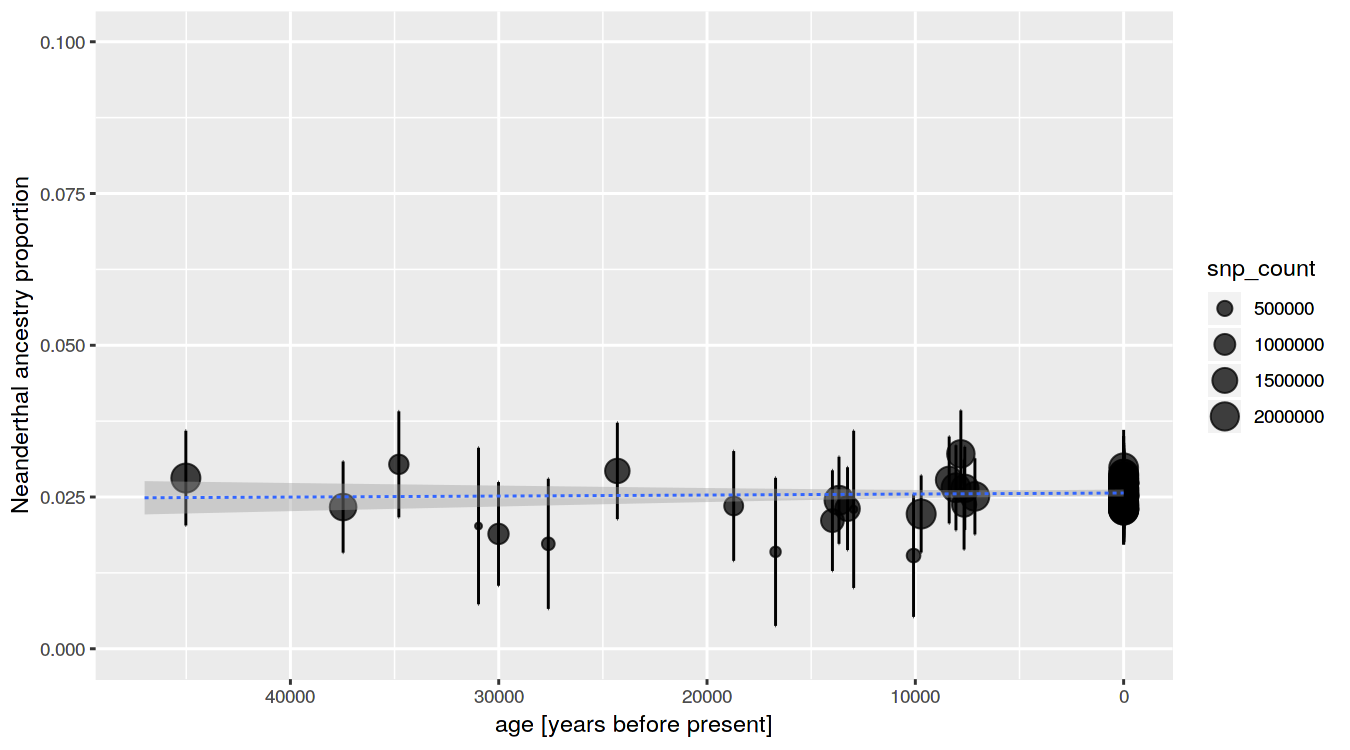

In [35]:
eur_nea %>% filter(stat == "direct_f4", C == "Yoruba") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

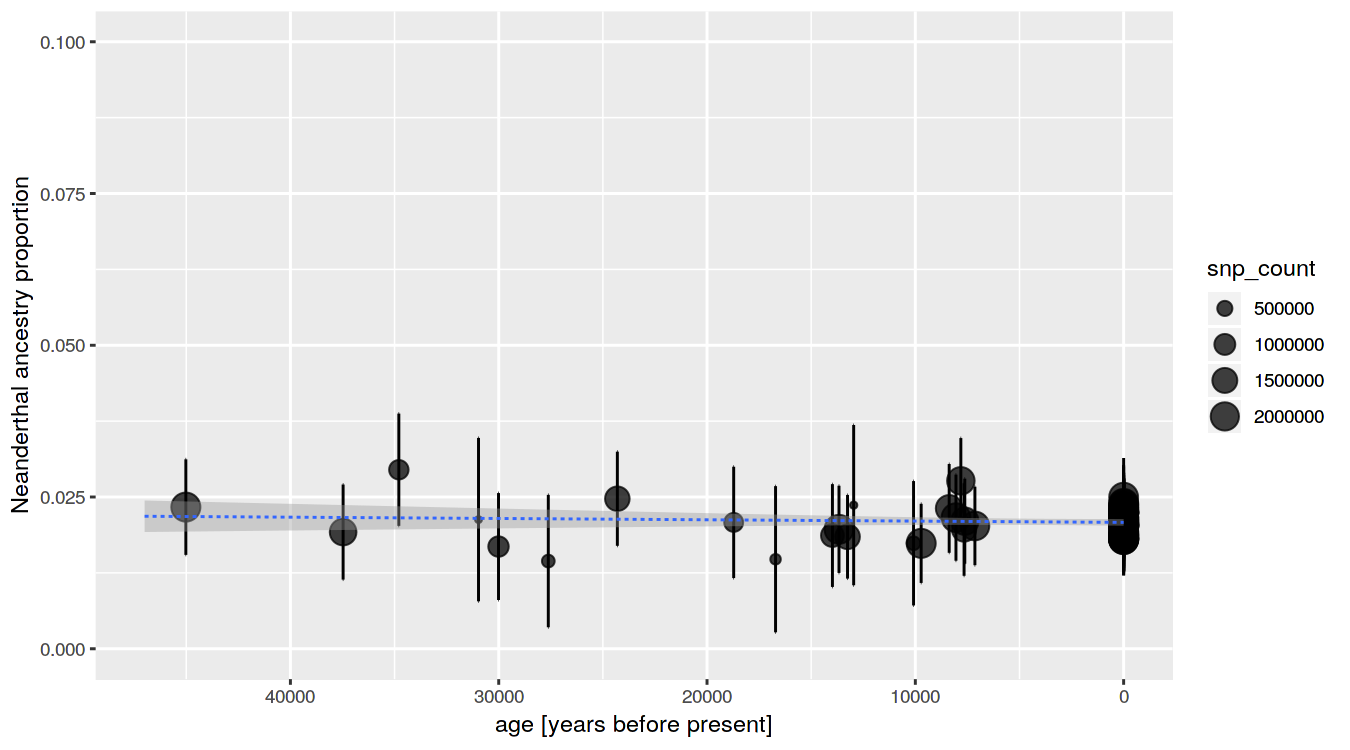

In [36]:
eur_nea %>% filter(stat == "direct_f4", C == "Mende") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

# Write the admixture array estimates

In [37]:
saveRDS(results, here("data/rds/nea_estimates.rds"))

In [38]:
results <- readRDS(here("data/rds/nea_estimates.rds"))

## Tianyuan

In [39]:
tianyuan_nea <- bind_rows(

relabel(snps,
        West_and_Central_Africans = c("Yoruba", "Mbuti", "Mende"),
        Archaics = c("new_Altai", "new_Denisova")) %>%
f4ratio(
    X = c("UstIshim", "TY"),
    A = "West_and_Central_Africans", B = "Archaics", C = "Dinka", O = "Chimp"
) %>% mutate(stat = "indirect_f4")

,

future_map_dfr(c("Dinka", "Yoruba"), ~
    f4ratio(X = c("UstIshim", "TY"),
            A = "new_Altai", B = "new_Vindija", C = .x, O = "Chimp", data = snps) %>% mutate(stat = "direct_f4"))

)

In [40]:
tianyuan_nea %>% select(X, stat, alpha, stderr, Zscore) %>% arrange(X)

X,stat,alpha,stderr,Zscore
TY,indirect_f4,0.047267,0.004649,10.166
TY,direct_f4,0.020975,0.004227,4.962
TY,direct_f4,0.022371,0.004048,5.526
UstIshim,indirect_f4,0.044160,0.004561,9.682
UstIshim,direct_f4,0.025595,0.003804,6.727
UstIshim,direct_f4,0.028119,0.003905,7.201
